# **Summary of problem statement, data and findings.**

**Problem Statement :**

A critical aspect of any IT function is 24/7/365 availability of its applications, also known in Business jargons as "“Keeping the lights on!".

Companies often employ Incident Management processes to address any unplanned interruption to an IT service or reduction in the quality of an IT service that affects the Users and the Business, also known as an "incident".The main goal of Incident Management process is to provide a quick fix / workarounds or solutions that resolves the interruption and restores the service to its full capacity to ensure no business impact.

The key is to assign the incoming incidents to correct stakeholder team (or Assignement Group) and to do it quickly in order to reduce that overall turn around time (TAT). This process, if done manually, is prone to errors as well as delays, which can bring down the overall Customer Satisfaction.

<u>In this capstone project, the goal is to automate the Incident Assignment process by building a classifier that can classify the tickets by analyzing text using NLP libraries.</u>

**Data Provided :**

A snapshot of the provided dataset.

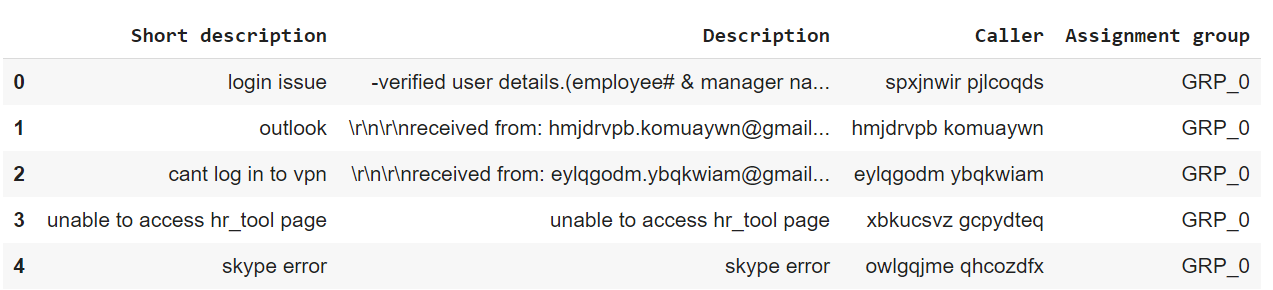


Here the data provided consists of below 4 columns :

1. Short Description : A brief introduction of the reported issue.  
2. Description : Details of the reported issue.
3. Caller : One who has reported the issue.
4. Assignment Group : The team which is responsible for providing resolution of issue to the caller.

<b>Initial Findings :</b> 

We observe that the columns 'Short Description' and 'Description' are of vital importance to draw a pattern in the incidents and related them to a particular 'Assignment Group' which is our target variable here. Since, the column 'Caller' does not contribute in the classification of tickets, it can be safely deleted during EDA before moving onto Text Preprocessing stage.


<br /><br />
We'll start out by importing the libraries essential for executing this project.









# Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
import re

# ftfy (Fixes Text For You) to check the given text for weird characters
!pip install ftfy
from ftfy import fix_text, badness

# google_translator to translate non-English text into English
!pip install google-trans-new
from google_trans_new import google_translator

# spacy to lemmatize the english description
!pip3 install spacy
!python3 -m spacy download en_core_web_sm
import spacy

# nltk for tokenization
import nltk
nltk.download('punkt')

from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dropout, Dense, BatchNormalization

import os
from google.colab import drive

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Then we'll mount our drive and change the directory to our project folder.

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.chdir('/content/drive/MyDrive/NLP Capstone Project/')

# Read the data

In [7]:
data = pd.read_excel('input_data.xlsx')
data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In order to facilitate usage of column names in dot notation calling in the subsequent EDA steps, we have renamed the given 2-word column names into a single word name.

In [9]:
data.rename(columns = {'Short description': 'short_description', 'Description': 'description', 'Caller': 'caller', 'Assignment group': 'assignment_group'}, inplace = True)
data.head()

,short_description,description,caller,assignment_group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


**Summary of the Approach to EDA and Pre-processing**

We will start with simple EDA operations like checking the datatypes, null values and duplicates in the given dataset.Then we will delete the unwanted 'Caller' column, before proceeding to Data Visualization.

In Data Visualization, we will study the distribution of data across different assignment groups to understand the balance of the data. This will be followed by Text Preprocessing.

Text Preprocessing will contain following major steps :

1. Fixing broken unicode text using **ftfy**.
2. Translate non-English text into English using **google_translator**.
3. Clean the data by removing unwanted text using Regex (**re**).
4. Lemmatise the resulting text using **spacy**.
5. Visualise the word frequency and wordcloud.

# EDA and Data Pre-processing

In [10]:
data.describe()

,short_description,description,caller,assignment_group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


Quick insights from above brief description of given dataset :


1. The count of columns differ from each other indicating presence of null values in the data.
2. None of the columns have all unique values.
3. There are in total **74** assignment groups to which any incident is assigned to.
4. <b>'GRP_0'</b> is the most frequently used assignment group with 3976 instances out of a total of 8500 samples <u>indicating an imbalance in the target variable data</u>. 



In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   short_description  8492 non-null   object
 1   description        8499 non-null   object
 2   caller             8500 non-null   object
 3   assignment_group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


This further confirms that there are in total <u>8 null values in column 'Short description' and 1 null value in column 'Description'.</u>

Before treating the null values, let us first check if there are any duplicate records in the given dataset.

In [12]:
dup_rows = data[data.duplicated()]
dup_rows

,short_description,description,caller,assignment_group
51,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0
229,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0
493,ticket update on inplant_872730,ticket update on inplant_872730,fumkcsji sarmtlhy,GRP_0
512,blank call //gso,blank call //gso,rbozivdq gmlhrtvp,GRP_0
667,job bkbackup_tool_powder_prod_full failed in j...,received from: monitoring_tool@company.com\r\n...,bpctwhsn kzqsbmtp,GRP_8
...,...,...,...,...
7836,probleme mit erpgui \tmqfjard qzhgdoua,probleme mit erpgui \tmqfjard qzhgdoua,tmqfjard qzhgdoua,GRP_24
8051,issue on pricing in distributor_tool,we have agreed price with many of the distribu...,hbmwlprq ilfvyodx,GRP_21
8093,reset passwords for prgthyuulla ramdntythanjes...,the,boirqctx bkijgqry,GRP_17
8347,blank call // loud noise,blank call // loud noise,rbozivdq gmlhrtvp,GRP_0


Since, duplicate rows won't contribute anything to the final classification process, we will keep the first record and remove the rest in case of each duplicate row.

In [13]:
data.drop_duplicates(keep='first',inplace=True,ignore_index=True)
print(data.info())
data[data.duplicated()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8417 entries, 0 to 8416
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   short_description  8409 non-null   object
 1   description        8416 non-null   object
 2   caller             8417 non-null   object
 3   assignment_group   8417 non-null   object
dtypes: object(4)
memory usage: 263.2+ KB
None


,short_description,description,caller,assignment_group


Now that we have removed the duplicate rows, let us check for the null values in the dataset.

In [14]:
data.isnull().sum()

short_description    8
description          1
caller               0
assignment_group     0
dtype: int64

These are the exact rows where we have null values.

In [15]:
data[pd.isnull(data).any(axis=1)]

,short_description,description,caller,assignment_group
2588,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3359,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3878,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3881,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3886,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3892,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3895,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4308,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0
4361,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


To treat null values, either we can remove the entire row or we can replace the null values with empty strings.

We are choosing the second approach as it will not affect any important text that we have in other columns. Also, empty string won't affect the string manipulations that we will have to do when we process the text before trying it on various models.

In [16]:
data.fillna(str(), inplace=True)
data[pd.isnull(data).any(axis=1)]

,short_description,description,caller,assignment_group


In [17]:
data.isnull().sum()

short_description    0
description          0
caller               0
assignment_group     0
dtype: int64

As we mentioned earlier, deleting the 'Caller' column as it adds no value to the final classification process.

In [18]:
del data['caller']
data.head()

,short_description,description,assignment_group
0,login issue,-verified user details.(employee# & manager na...,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


# Data Visualization

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


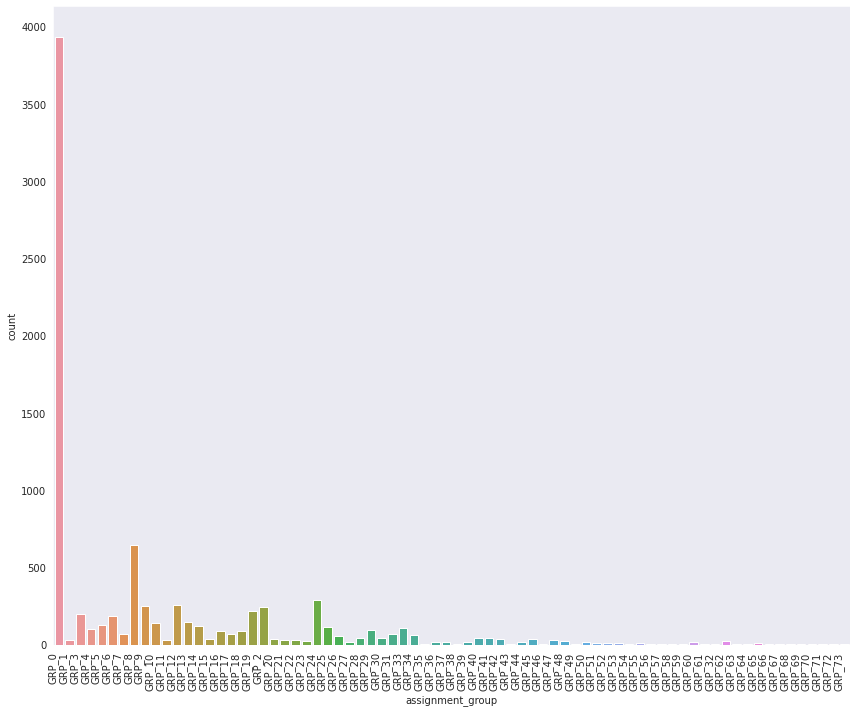

In [19]:
sns.set_style("dark")
plt.figure(figsize=(12,10))
ax = sns.countplot(data.assignment_group)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=10)
plt.tight_layout()
plt.show()

We can see above that out of a total of 74 assignment groups, only first 35 groups have significant number of ticket assignment.

So, we are clubbing all those assignment groups under the name **Others**, whose ticket count is less than 30 in order to keep the data in our target column meaningful and to reduce unnecessary complication in the final classification process.

In [20]:
groups = data.assignment_group.unique()
print("Initial number of assignment groups : ",len(groups))
for gr in groups:
  if data[data['assignment_group']==gr].shape[0] <= 30:
    data.loc[(data.assignment_group == gr),'assignment_group']='Others'
print(data.groupby(['assignment_group'])['description'].count())
groups = data.assignment_group.unique()
print("Final number of assignment groups : ",len(groups))

Initial number of assignment groups :  74
assignment_group
GRP_0     3934
GRP_1       31
GRP_10     140
GRP_12     257
GRP_13     145
GRP_14     118
GRP_15      38
GRP_16      85
GRP_17      68
GRP_18      88
GRP_19     215
GRP_2      241
GRP_20      36
GRP_22      31
GRP_24     285
GRP_25     116
GRP_26      56
GRP_28      44
GRP_29      97
GRP_3      200
GRP_30      39
GRP_31      69
GRP_33     107
GRP_34      62
GRP_4      100
GRP_40      45
GRP_41      40
GRP_42      37
GRP_45      35
GRP_5      128
GRP_6      183
GRP_7       68
GRP_8      645
GRP_9      252
Others     382
Name: description, dtype: int64
Final number of assignment groups :  35


So from 74 assignment groups, we have reduced the number to 35. Let us confirm that by plotting the bar graph again.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


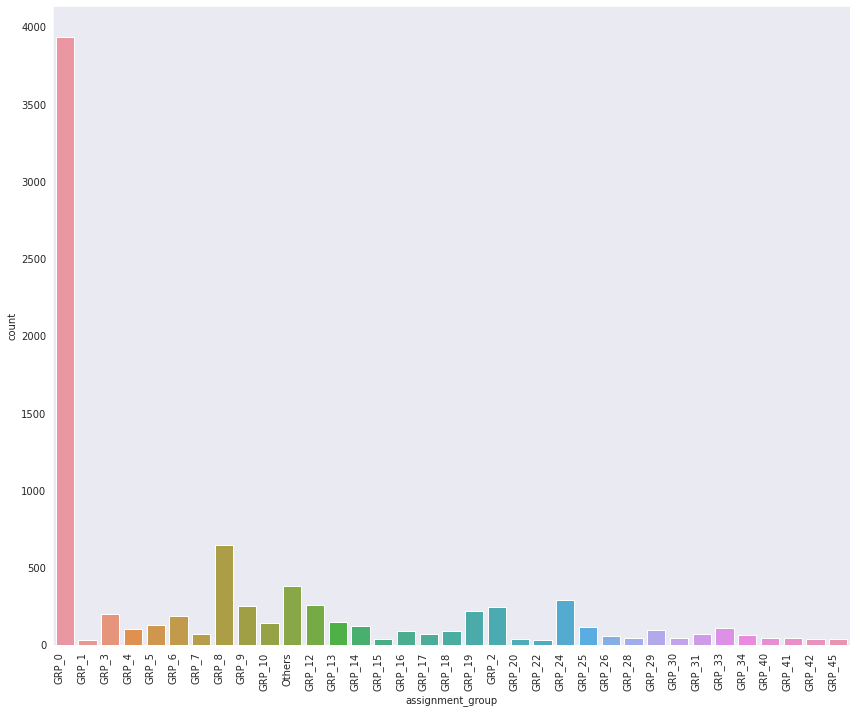

In [21]:
sns.set_style("dark")
plt.figure(figsize=(12,10))
ax = sns.countplot(data.assignment_group)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=10)
plt.tight_layout()
plt.show()

Let us check the individual contribution of each of these assignment groups in a pie chart to see the distribution of samples in the given dataset.

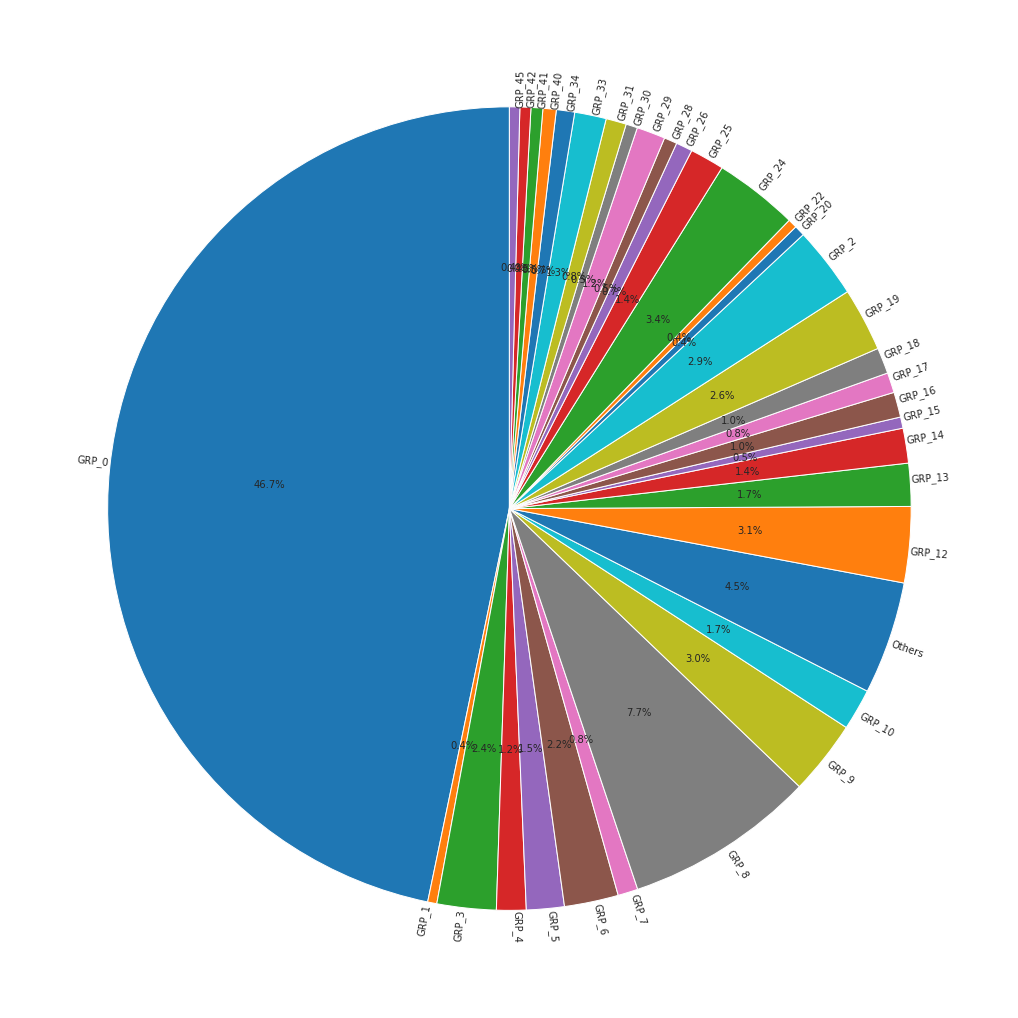

In [22]:
counts = [] 
for gr in groups:
  counts.append(data[data['assignment_group']==gr].shape[0])
  
# Creating plot 
fig = plt.figure(figsize =(18, 20)) 
plt.pie(counts, labels = data.assignment_group.unique(),autopct='%1.1f%%',startangle=90,rotatelabels=True,labeldistance=1.0) 
  
# show plot 
plt.show() 

Quick insights from the data visualisation :

1. **'GRP_0'** at **46.7%** covers the largest pie in the distribution, further confirming our initial assumption of imbalance in the data.
2. GRP_0 is followed by **'GRP_8'** at **7.7%**, **Others** at **4.5%** etc.



# Text Preprocessing

In natural language processing, text preprocessing is the practice of cleaning and preparing text data. NLTK and re are common Python libraries used to handle many text preprocessing tasks.

**ftfy: fixes text for you**

<u>ftfy fixes Unicode that’s broken in various ways.</u>The goal of ftfy is to take in bad Unicode and output good Unicode, for use in your Unicode-aware code.

The most interesting kind of brokenness that ftfy will fix is when someone has encoded Unicode with one standard and decoded it with a different one. This often shows up as characters that turn into nonsense sequences (called “<b><u>mojibake</u></b>”). For example : 

* The word schön might appear as schÃ¶n.
* An em dash (—) might appear as â€”.

Methods used in this project :

**badness.sequence_weirdness :** Determine how often a text has unexpected characters or sequences of characters. This metric is used to disambiguate when text should be re-decoded or left as is.

**fix_text :** It will run text through a sequence of fixes. If the text changed, it will run them through again, so that you can be sure the output ends up in a standard form that will be unchanged by ftfy.fix_text().


In [23]:
# Function to detect weird characters in text
def has_weird_characters(text):
  # no changes required if no weird character present
  if not badness.sequence_weirdness(text):
    return True
  try:
    text.encode('sloppy-windows-1252')
  # Not encodable as CP-1252
  except UnicodeEncodeError:    
    return True
  # Encodable as CP-1252
  else:    
    return False
    
# Check the dataset for weird characters
data[~data.iloc[:,:-1].applymap(has_weird_characters).all(1)]

,short_description,description,assignment_group
98,password expiry tomorrow,\n\nreceived from: ecprjbod.litmjwsy@gmail.com...,GRP_0
115,server issues,\r\n\r\nreceived from: bgqpotek.cuxakvml@gmail...,GRP_0
123,mobile device activation,"from: tvcdfqgp nrbcqwgj \nsent: friday, octobe...",GRP_0
163,æ’¤å›ž: ticket_no1564867 -- comments added,\n\nreceived from: abcdri@company.com\n\nwindy...,GRP_0
169,[urgent!!] delivery note creation request!!,\n\nreceived from: fbvpcytz.nokypgvx@gmail.com...,GRP_18
...,...,...,...
8387,please review your recent ticketing_tool ticke...,"from: mikhghytr wafglhdrhjop \nsent: thursday,...",GRP_16
8388,ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,to å°è´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,GRP_30
8397,customer group enhanced field,\r\n\r\nreceived from: nlearzwi.ukdzstwi@gmail...,GRP_9
8415,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,Others


We have a total of 825 rows which have weird characters or mojibakes which need fixing using ftfy.

In [24]:
# An example of fixing weird characters in text
print('Weird text: \033[1m%s\033[0m\nFixed text: \033[1m%s\033[0m' % (data['short_description'][8388],
                                                                        fix_text(data['short_description'][8388])))

Weird text: ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥
Fixed text: 电脑开机开不出来


In [25]:
# Remove weird characters from dataset
data['short_description'] = data['short_description'].apply(fix_text)
data['description'] = data['description'].apply(fix_text)

# Visualize any of the affected rows
data.iloc[8388,:]

short_description            电脑开机开不出来
description          to 小贺,早上电脑开机开不出来
assignment_group               GRP_30
Name: 8388, dtype: object

Saving the treated data so far in a pickle file so that we can directly start from this point in future if needed. 

In [26]:
# Serialize the above treated dataset
data.to_csv('treated_data.csv', index=False, encoding='utf_8_sig')
with open('treated_data.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
!pip install google-trans-new

In [28]:
translator = google_translator()

data.insert(loc=2, column='language', value=np.nan, allow_duplicates=True)

# Step 1 : Identify the language of the current data
cols_for_transl = ['short_description','description']
for idx in range(data.shape[0]):
  data.language[idx] = translator.detect(' '.join(data.loc[idx, cols_for_transl]))

In [89]:
# Step 2: Translate non-English text into English
for idx in range(data.shape[0]):
  try:
      if data.language[idx] is not ['en', 'english']:
        data.short_description[idx] = translator.translate(data.short_description[idx],lang_tgt='en')
        data.description[idx] = translator.translate(data.description[idx],lang_tgt='en')
      else:
        pass
  except:
    print('Index of untranslated row : ' + str(idx))
    print('Short Description : ' + data.short_description[idx])
    print('Description : ' + data.description[idx])
    print('-'*100)
    pass


Index of untranslated row : 6312
Short Description : authorization add/delete members 
Description :  


----------------------------------------------------------------------------------------------------
Index of untranslated row : 7322
Short Description : browser issue : 
Description : 

----------------------------------------------------------------------------------------------------


In [94]:
# Serialize the translated dataset
data.to_csv('translated_data.csv', index=False, encoding='utf_8_sig')
with open('translated_data.pkl','wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [168]:
# Load the translated pickle file
with open('translated_data.pkl','rb') as f:
    data = pickle.load(f)
data.head()

,short_description,description,language,assignment_group
0,login issue,-verified user details.(employee# & manager na...,"[en, english]",GRP_0
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com\n\n...,"[en, english]",GRP_0
2,cant log in to vpn,received from: eylqgodm.ybqkwiam@gmail.com\n\n...,"[en, english]",GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,"[en, english]",GRP_0
4,skype error,skype error,"[en, english]",GRP_0


In [170]:
# Regex patterns
EMAIL_PATTERN = r"([\w.+-]+@[a-z\d-]+\.[a-z\d.-]+)"
PUNCTUATION_PATTERN = r"[,|@|\|?|\\|$&*|%|\r|\n|.:|\s+|/|//|\\|/|\||-|<|>|;|(|)|=|+|#|-|\"|[-\]]|{|}]" 
NUMBER_PATTERN = r"(\d+(?:\.\d+)?)"

# Function to process the ticket text
def cleanText(text):
    # Make the text unicase (lower) 
    text = str(text).lower()
    # Remove email adresses
    text = re.sub(EMAIL_PATTERN, '', text, flags=re.IGNORECASE) # check for duplicates after this
    # Remove all numbers 
    text = re.sub(NUMBER_PATTERN, '', text)
    # Replace all punctuations with blank space
    text = re.sub(PUNCTUATION_PATTERN, " ", text, flags=re.MULTILINE)
    # Replace multiple spaces from prev step to single
    text = re.sub(r' {2,}', " ", text, flags=re.MULTILINE)
    text = text.replace('`',"'")
    text = text.replace('-verified','verified')
    return text.strip()

In [171]:
# Checking 'cleanText' function with an example
print('\033[1mOriginal text:\033[0m')
print(data['description'][32])
print('_'*100)
print('\033[1mCleaned text:\033[0m')
print(cleanText(data['description'][32]))

Original text:
received from: kxsceyzo.naokumlb@gmail.com

gentles,

i have two devices that are trying to share an ip address. they are trying to share 96.26.27.9619. one is a printer with the hostname of prtjc0074, and the other is a new display for erp. the display is using dhcp to get its address assigned and the printer is hard coded.

my guess is that the address 96.26.27.9619 did not get set to a static address in dhcp. i need this corrected so the display will pick up another address. 
____________________________________________________________________________________________________
Cleaned text:
received from gentles i have two devices that are trying to share an ip address they are trying to share one is a printer with the hostname of prtjc and the other is a new display for erp the display is using dhcp to get its address assigned and the printer is hard coded my guess is that the address did not get set to a static address in dhcp i need this corrected so the display will

In [172]:
# Apply the cleaning function to entire dataset
data['description'] = data['description'].apply(cleanText)
data['short_description'] = data['short_description'].apply(cleanText)

# Verify the data
data.head()

,short_description,description,language,assignment_group
0,login issue,verified user details employee manager name -c...,"[en, english]",GRP_0
1,outlook,received from hello team my meetings skype mee...,"[en, english]",GRP_0
2,cant log in to vpn,received from hi i cannot log on to vpn best,"[en, english]",GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,"[en, english]",GRP_0
4,skype error,skype error,"[en, english]",GRP_0


In [173]:
data.head()

,short_description,description,language,assignment_group
0,login issue,verified user details employee manager name -c...,"[en, english]",GRP_0
1,outlook,received from hello team my meetings skype mee...,"[en, english]",GRP_0
2,cant log in to vpn,received from hi i cannot log on to vpn best,"[en, english]",GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,"[en, english]",GRP_0
4,skype error,skype error,"[en, english]",GRP_0


In [174]:
# Initialize spacy 'en' medium model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define a function to lemmatize the descriptions
def lemmatizer(sentence):
    # Parse the sentence using the loaded 'en' model object `nlp`
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc if token.lemma_ !='-PRON-'])

In [175]:
# Take an example of row# 43 Description and lemmatize it
print('\033[1mOriginal text:\033[0m')
print(data['description'][100])
print('_'*100)
print('\033[1mLemmatized text:\033[0m')
print(lemmatizer(data['description'][100]))

Original text:
received from hi below mentioned employee krlszbqo spimolgz with user id sv is not able to login to ess portal to access his pay slips and related contents he is a attendance_tool user please reset his user id and password and revert back
____________________________________________________________________________________________________
Lemmatized text:
receive from hi below mention employee krlszbqo spimolgz with user would sv be not able to login to ess portal to access pay slip and related content be a attendance_tool user please reset user would and password and revert back


In [176]:
# Apply the Lemmatization to entire dataset
data['description'] = data['description'].apply(lemmatizer)
data['short_description'] = data['short_description'].apply(lemmatizer)

# Verify the data
data.head()

,short_description,description,language,assignment_group
0,login issue,verify user detail employee manager name -chec...,"[en, english]",GRP_0
1,outlook,receive from hello team meeting skype meeting ...,"[en, english]",GRP_0
2,can not log in to vpn,receive from hi i can not log on to vpn best,"[en, english]",GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,"[en, english]",GRP_0
4,skype error,skype error,"[en, english]",GRP_0


In [177]:
# Serialize the preprocessed dataset
data.to_csv('preprocessed_data.csv', index=False, encoding='utf_8_sig')
with open('preprocessed_data.pkl','wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


In [178]:
# Load the preprocessed pickle file
with open('preprocessed_data.pkl','rb') as f:
  data = pickle.load(f)
data.head()

,short_description,description,language,assignment_group
0,login issue,verify user detail employee manager name -chec...,"[en, english]",GRP_0
1,outlook,receive from hello team meeting skype meeting ...,"[en, english]",GRP_0
2,can not log in to vpn,receive from hi i can not log on to vpn best,"[en, english]",GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,"[en, english]",GRP_0
4,skype error,skype error,"[en, english]",GRP_0


In [179]:
# Create new features of length and word count for both of the description columns
data.insert(1, 'sd_len', data['short_description'].astype(str).apply(len))
data.insert(2, 'sd_word_count', data['short_description'].apply(lambda x: len(str(x).split())))
data.insert(4, 'desc_len', data['description'].astype(str).apply(len))
data.insert(5, 'desc_word_count', data['description'].apply(lambda x: len(str(x).split())))
data.head()

,short_description,sd_len,sd_word_count,description,desc_len,desc_word_count,language,assignment_group
0,login issue,11,2,verify user detail employee manager name -chec...,180,32,"[en, english]",GRP_0
1,outlook,7,1,receive from hello team meeting skype meeting ...,135,23,"[en, english]",GRP_0
2,can not log in to vpn,21,6,receive from hi i can not log on to vpn best,44,11,"[en, english]",GRP_0
3,unable to access hr_tool page,29,5,unable to access hr_tool page,29,5,"[en, english]",GRP_0
4,skype error,11,2,skype error,11,2,"[en, english]",GRP_0


In [180]:
# Extend the English Stop Words
STOP_WORDS = STOPWORDS.union({'yes','na','hi',
                              'receive','hello',
                              'regards','thanks',
                              'from','greeting',
                              'forward','reply',
                              'will','please',
                              'see','help','able'})

# Function to generate Wordcloud
def generate_wordcloud(corpus):
    # Instantiate the wordcloud object
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=STOP_WORDS,
                    min_font_size = 10).generate(corpus)

    # Plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

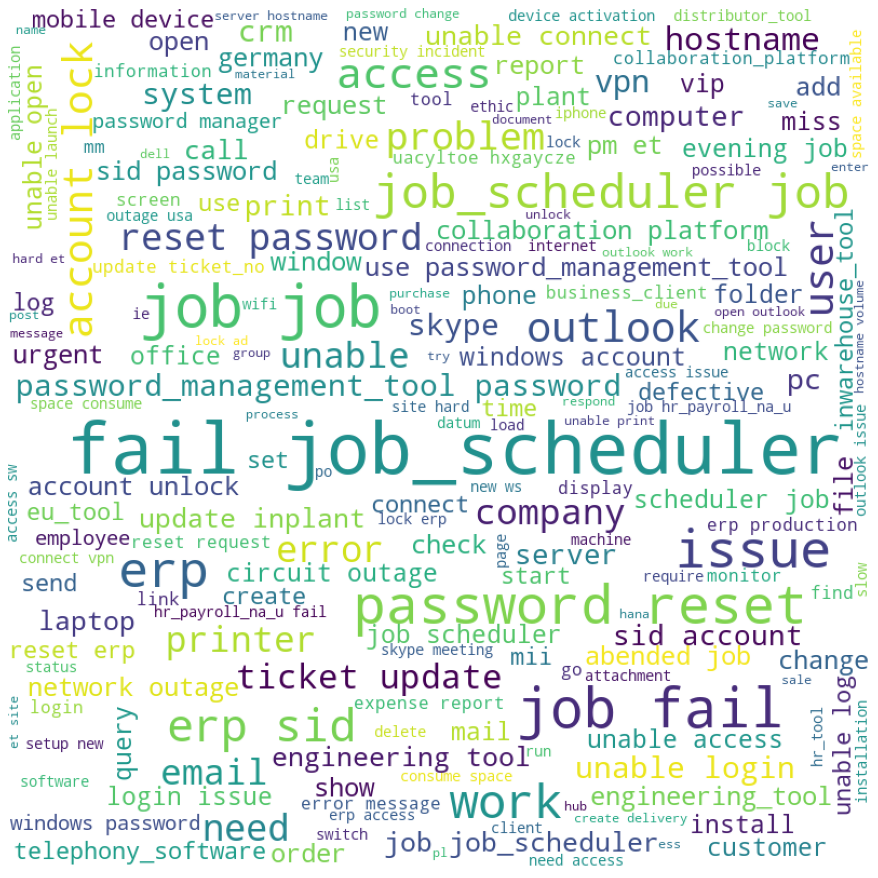

In [181]:
# Wordcloud for short description
generate_wordcloud(' '.join(data['short_description'].str.strip()))

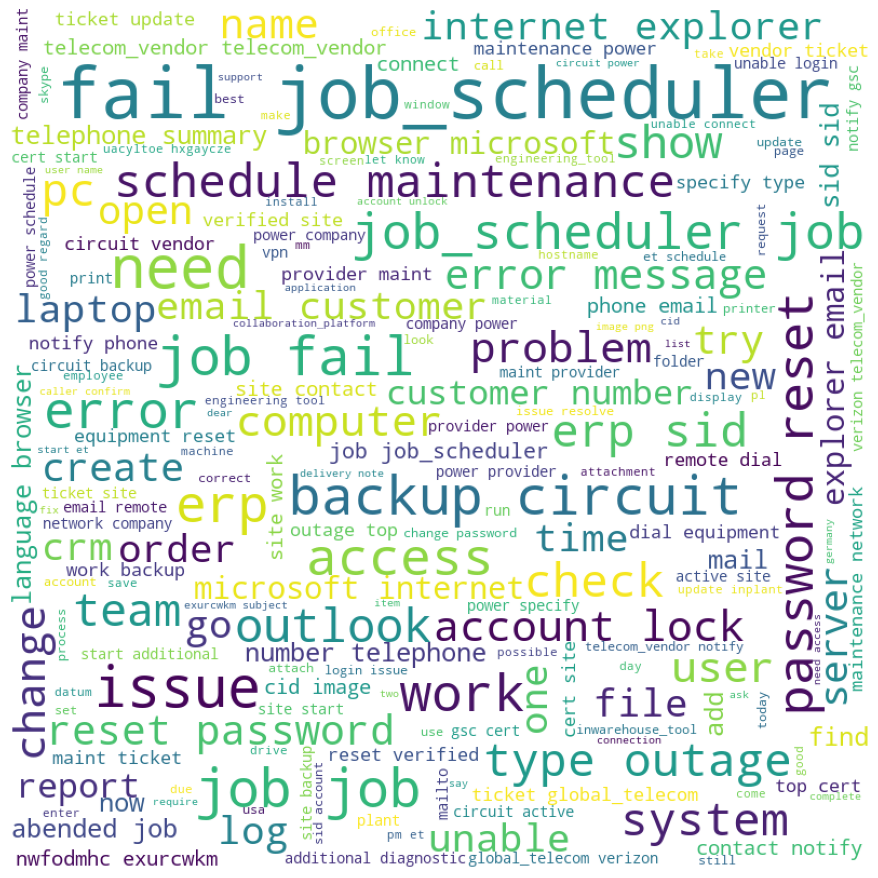

In [182]:
# Wordcloud for description
generate_wordcloud(' '.join(data['description'].str.strip()))

In [183]:
# Function to generate Word Frequency
def generate_wordFreq(corpus):
  tokens = nltk.tokenize.word_tokenize(text=corpus)
  fd = nltk.FreqDist(tokens)
  fd.plot(30,cumulative=False)

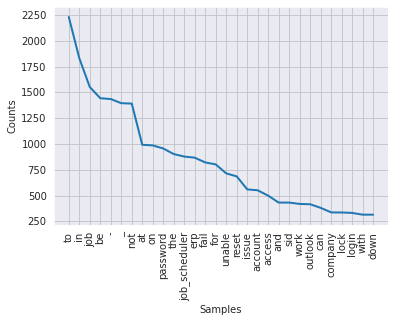

In [184]:
# Generate Word Frequency for short description
generate_wordFreq(' '.join(data['short_description'].str.strip()))

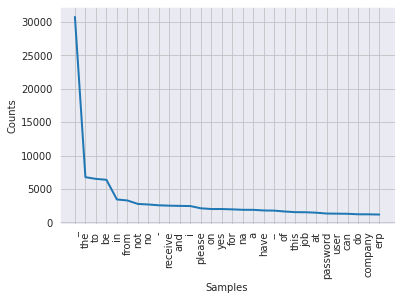

In [185]:
# Generate Word Frequency for description
generate_wordFreq(' '.join(data['description'].str.strip()))

In [186]:
# Serialize the dataset after EDA and Preprocessing
with open('model_ready_data.pkl','wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [187]:
# Load the preprocessed pickle file
with open('model_ready_data.pkl','rb') as f:
  data = pickle.load(f)
data.head()

,short_description,sd_len,sd_word_count,description,desc_len,desc_word_count,language,assignment_group
0,login issue,11,2,verify user detail employee manager name -chec...,180,32,"[en, english]",GRP_0
1,outlook,7,1,receive from hello team meeting skype meeting ...,135,23,"[en, english]",GRP_0
2,can not log in to vpn,21,6,receive from hi i can not log on to vpn best,44,11,"[en, english]",GRP_0
3,unable to access hr_tool page,29,5,unable to access hr_tool page,29,5,"[en, english]",GRP_0
4,skype error,11,2,skype error,11,2,"[en, english]",GRP_0


In [188]:
# Create two new columns - word_collection and target
data['word_collection'] = data['short_description'].str.strip() + ' ' + data['description'].str.strip()
data['target'] = data['assignment_group'].astype('category').cat.codes
data.head()

,short_description,sd_len,sd_word_count,description,desc_len,desc_word_count,language,assignment_group,word_collection,target
0,login issue,11,2,verify user detail employee manager name -chec...,180,32,"[en, english]",GRP_0,login issue verify user detail employee manage...,0
1,outlook,7,1,receive from hello team meeting skype meeting ...,135,23,"[en, english]",GRP_0,outlook receive from hello team meeting skype ...,0
2,can not log in to vpn,21,6,receive from hi i can not log on to vpn best,44,11,"[en, english]",GRP_0,can not log in to vpn receive from hi i can no...,0
3,unable to access hr_tool page,29,5,unable to access hr_tool page,29,5,"[en, english]",GRP_0,unable to access hr_tool page unable to access...,0
4,skype error,11,2,skype error,11,2,"[en, english]",GRP_0,skype error skype error,0


In [189]:
# Create train and test datasets with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(data.word_collection, 
                                                    data.target, 
                                                    test_size=0.20, 
                                                    random_state=42)
print('Shape of the training set:', X_train.shape, X_test.shape)
print('Shape of the test set:', y_train.shape, y_test.shape)

Shape of the training set: (6733,) (1684,)
Shape of the test set: (6733,) (1684,)


In [190]:
# Function for running various model
def run_model(model, X_train, X_test, y_train, y_test):
  model = Pipeline([
           ('vec',CountVectorizer()),
           ('tranform',TfidfTransformer()),
           ('clf', model)       
  ])
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_train_pred = model.predict(X_train)
  print('Classifier:', model.named_steps.clf)
  print('-'*100)
  print_accuracy(y_train,y_train_pred,y_test,  y_pred)


def print_accuracy(y_train,y_train_pred,y_test,  y_pred):
  print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
  print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
  print('-'*100)
  print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
  print('-'*100)
  print('Classification report:\n %s' % (classification_report(y_test, y_pred)))

**Deciding Models and Model Building**

Since this is a multi-class classification problem, below list of models should be appropriate in this case.

1. Multinomial Naive Bayes
2. k-Nearest Neighbour Classifier
3. Linear SVM Classifier
4. Decision Tree Classifier
5. Random Forest Classifier
6. Logistic Regression
7. AdaBoost Classifier
8. Gradient Boosting Classifier
9. XGBoost Classifier
10. Bagging Classifier
11. SGD Classifier
12. Neural Network

# Multinomial Naive Bayes

In [191]:
run_model(MultinomialNB(),X_train, X_test, y_train, y_test)

Classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
----------------------------------------------------------------------------------------------------
Training accuracy: 55.86%
Testing accuracy: 54.16%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[783   0   0 ...   0   0   0]
 [  2   0   0 ...   1   0   0]
 [ 16   0   0 ...  15   0   0]
 ...
 [ 10   0   0 ... 112   0   0]
 [ 14   0   0 ...  41   0   0]
 [ 73   0   0 ...   2   0   0]]
----------------------------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71       783
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        31
           3       0.70      0.11      0.19        62
           4       0.00      0.00      0.00        35
           5   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# k-Nearest Neighbour Classifier

In [192]:
run_model(KNeighborsClassifier(),X_train, X_test, y_train, y_test)

Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
----------------------------------------------------------------------------------------------------
Training accuracy: 71.75%
Testing accuracy: 65.50%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[760   0   0 ...   0   0   6]
 [  0   1   0 ...   1   0   1]
 [ 10   0  16 ...   1   1   1]
 ...
 [  4   0   1 ...  94   6   0]
 [  8   0   0 ...  30  14   0]
 [ 46   0   2 ...   1   0  12]]
----------------------------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.68      0.97      0.80       783
           1       1.00      0.33      0.50         3
           2       0.73      0.52      0.60      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Linear SVM Classifier

In [193]:
run_model(LinearSVC(),X_train, X_test, y_train, y_test)


Classifier: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
----------------------------------------------------------------------------------------------------
Training accuracy: 92.47%
Testing accuracy: 68.65%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[736   0   2 ...   0   1  10]
 [  0   0   0 ...   1   0   2]
 [  2   0  21 ...   1   1   3]
 ...
 [  3   0   1 ... 100   6   0]
 [  3   0   0 ...  30  15   3]
 [ 36   0   1 ...   3   0  22]]
----------------------------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83       783
           1       0.00      0.00      0.00         3
      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree Classifier

In [194]:
run_model(DecisionTreeClassifier(),X_train, X_test, y_train, y_test)

Classifier: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
----------------------------------------------------------------------------------------------------
Training accuracy: 95.68%
Testing accuracy: 56.24%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[651   0   1 ...   0   3  19]
 [  0   0   0 ...   2   0   1]
 [  9   0  15 ...   1   1   1]
 ...
 [  4   0   1 ...  85   6   0]
 [  6   0   0 ...  30  10   4]
 [ 32   0   0 ...   2   2  15]]
-------------------------------------------------------------------------------------------------

# Random Forest Classifier

In [195]:
run_model(RandomForestClassifier(),X_train, X_test, y_train, y_test)

Classifier: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
----------------------------------------------------------------------------------------------------
Training accuracy: 95.68%
Testing accuracy: 62.89%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[779   0   0 ...   0   0   1]
 [  1   0   0 ...   1   0   0]
 [ 16   0  13 ...   1   1   0]
 ...
 [  6   0   1 ...  99   6   0]
 [ 13   0   0 ...  30   9   1]
 [ 65   0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression

In [196]:
run_model(LogisticRegression(),X_train, X_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
----------------------------------------------------------------------------------------------------
Training accuracy: 70.35%
Testing accuracy: 64.13%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[774   0   0 ...   0   0   3]
 [  0   0   0 ...   1   0   2]
 [ 13   0  13 ...   2   1   2]
 ...
 [  6   0   1 ... 101   6   0]
 [  8   0   0 ...  30  10   4]
 [ 60   0   0 ...   3   0   8]]
----------------------------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# AdaBoost Classifier

In [197]:
run_model(AdaBoostClassifier(n_estimators=1000),X_train, X_test, y_train, y_test)

Classifier: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=1000, random_state=None)
----------------------------------------------------------------------------------------------------
Training accuracy: 52.89%
Testing accuracy: 51.84%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[757   0   0 ...  21   0   0]
 [  1   0   0 ...   2   0   0]
 [ 16   0   0 ...  15   0   0]
 ...
 [ 12   0   0 ... 110   0   0]
 [ 13   0   0 ...  42   0   0]
 [ 72   0   0 ...   5   0   0]]
----------------------------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.55      0.97      0.70       783
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        31
           3       0.00      0.00      0.00  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Gradient Boosting Classifier

In [198]:
run_model(GradientBoostingClassifier(random_state=0),X_train, X_test, y_train, y_test)

Classifier: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
----------------------------------------------------------------------------------------------------
Training accuracy: 92.77%
Testing accuracy: 61.82%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[716   0   3 ...   1 

# XGBoost Classifier

In [199]:
run_model(xgb.XGBClassifier(),X_train, X_test, y_train, y_test)

Classifier: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
----------------------------------------------------------------------------------------------------
Training accuracy: 79.12%
Testing accuracy: 63.42%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[752   0   0 ...   0   1   2]
 [  2   0   0 ...   1   0   0]
 [ 10   0  17 ...   2   1   0]
 ...
 [  6   0   1 ... 100   6   0]
 [  8   0   0 ...  32  12   2]
 [ 64   0   0 ...   2   0   3]]
-------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Bagging Classifier

In [200]:
from sklearn.ensemble import BaggingClassifier
run_model(BaggingClassifier(),X_train, X_test, y_train, y_test)

Classifier: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
----------------------------------------------------------------------------------------------------
Training accuracy: 93.61%
Testing accuracy: 61.76%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[746   0   0 ...   0   0   7]
 [  0   0   0 ...   2   0   0]
 [ 11   0  13 ...   1   1   1]
 ...
 [  4   0   1 ...  87   7   0]
 [  9   0   0 ...  27  13   3]
 [ 53   1   0 ...   0   1  13]]
----------------------------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.64      0.95      0.77       783
           1       0.00  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SGD Classifier

In [201]:
from sklearn.linear_model import SGDClassifier
run_model(SGDClassifier(random_state=3),X_train, X_test, y_train, y_test)

Classifier: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=3, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
----------------------------------------------------------------------------------------------------
Training accuracy: 88.98%
Testing accuracy: 68.65%
----------------------------------------------------------------------------------------------------
Confusion matrix:
 [[741   0   2 ...   0   1   9]
 [  0   0   0 ...   0   0   2]
 [  5   0  18 ...   0   2   2]
 ...
 [  3   0   1 ...  65  38   0]
 [  3   0   0 ...   0  45   3]
 [ 33   0   1 ...   2   1  23]]
----------------------------------------------------------------------------------------------------
Cl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Neural Network

In [202]:
vect = TfidfVectorizer(max_features=5000)
vect.fit(data.word_collection)
X_train_vect = vect.transform(X_train).toarray()
X_test_vect = vect.transform(X_test).toarray()

model_NN = Sequential()
# number of nodes
node = 512
# number of  hidden layer
nLayers = 4 
# number of assignment groups
nClasses = 35
model_NN.add(Dense(node,input_dim=X_train_vect.shape[1],activation='relu'))
model_NN.add(Dropout(0.3))
for i in range(0,nLayers):
  model_NN.add(Dense(node,input_dim=node,activation='relu'))
  model_NN.add(Dropout(0.3))
  model_NN.add(BatchNormalization())
model_NN.add(Dense(nClasses, activation='softmax'))
model_NN.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
print(model_NN.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               2560512   
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)              

In [204]:
model_NN.fit(X_train_vect, 
             y_train,
             validation_data=(X_test_vect, y_test),
             epochs=50,
             batch_size=128,
             verbose=2)
y_pred = model_NN.predict(X_test_vect)
y_pred = np.argmax(y_pred, axis=1)
y_train_pred = model_NN.predict(X_train_vect)
y_train_pred = np.argmax(y_train_pred, axis=1)

give_accuracy(y_train,y_train_pred,y_test, y_pred)

Epoch 1/50
53/53 - 3s - loss: 0.2001 - accuracy: 0.9329 - val_loss: 2.1455 - val_accuracy: 0.6770
Epoch 2/50
53/53 - 3s - loss: 0.1977 - accuracy: 0.9342 - val_loss: 2.2142 - val_accuracy: 0.6657
Epoch 3/50
53/53 - 3s - loss: 0.2050 - accuracy: 0.9363 - val_loss: 2.2415 - val_accuracy: 0.6710
Epoch 4/50
53/53 - 3s - loss: 0.1952 - accuracy: 0.9344 - val_loss: 2.2164 - val_accuracy: 0.6669
Epoch 5/50
53/53 - 3s - loss: 0.1943 - accuracy: 0.9342 - val_loss: 2.2542 - val_accuracy: 0.6675
Epoch 6/50
53/53 - 3s - loss: 0.1861 - accuracy: 0.9363 - val_loss: 2.2864 - val_accuracy: 0.6805
Epoch 7/50
53/53 - 3s - loss: 0.1824 - accuracy: 0.9397 - val_loss: 2.3071 - val_accuracy: 0.6716
Epoch 8/50
53/53 - 3s - loss: 0.1729 - accuracy: 0.9378 - val_loss: 2.3810 - val_accuracy: 0.6740
Epoch 9/50
53/53 - 3s - loss: 0.1799 - accuracy: 0.9393 - val_loss: 2.2744 - val_accuracy: 0.6734
Epoch 10/50
53/53 - 3s - loss: 0.1732 - accuracy: 0.9398 - val_loss: 2.3969 - val_accuracy: 0.6645
Epoch 11/50
53/53 -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We got below accuracies with different models :

1. Multinomial Naive Bayes - 54%
2. k-Nearest Neighbour Classifier - 65%
3. Linear SVM Classifier - 69%
4. Decision Tree Classifier - 56%
5. Random Forest Classifier - 63%
6. Logistic Regression - 64%
7. AdaBoost Classifier - 52%
8. Gradient Boosting Classifier - 62%
9. XGBoost Classifier - 63%
10. Bagging Classifier - 62%
11. SGD Classifier - 69%
12. Neural Network - 67%

The accuracy across various models is consistently on the lower side.

**How to improve your model performance?**

We can adopt below performance tuning practices to improve our model performance.

1. Use of resampling to counter imbalance in data.
2. Use of Principal Component Analysis and Feature Selection techniques in Machine Learning models.
3. Use of Callbacks (Early Stopping), Checkpointing and saved weights in Neural Network.